In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms

# Dataset

MNIST dataset  
handwritten digits  
28x28 images  
10 classes (0-9)   

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

## Utils

In [3]:
# plot image after transposing for matplotlib

def show_image(img, title):    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [4]:
# make an image-grid with next batch and show
# also return
def show_image_batch(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    show_image(img, title=[str(x.item()) for x in labels])
    
    return images, labels

In [5]:
# dataloader

batch_size = 4
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

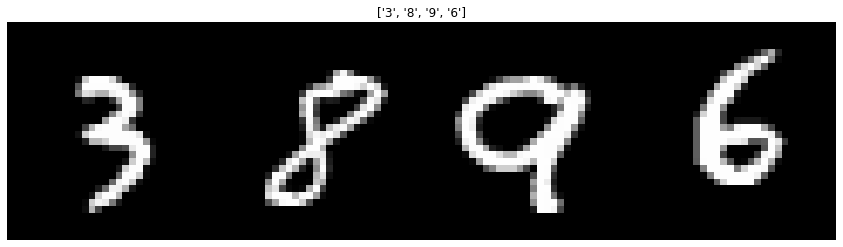

In [6]:
images, labels = show_image_batch(dataloader)

# Model - Batchnorm

In [7]:
# one n/w to do the classification
# fully connected n/w

class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # as 10 classes
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

batchnorm can be done on activations or preactivations. here, preactivations  

batchnorm'1d' - as we are working with 1d layer.  
arg - number of neurons

batchnorm implemented simply by adding such a layer in sequential.

In [8]:
# model with batch norm

class MyNetBN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [10]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


# Trian

In [11]:
# dataloader for this batch size
batch_size = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# loss function 
loss_fn = nn.CrossEntropyLoss()

# optimizer for model w/o BN
opt = optim.SGD(model.parameters(), lr=0.01)

# optimizer for model with BN
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

### simultaneously train two models . (two optimizers)

Normalization is over data points.  
distribution of one neuron values for different datapoints   

- in training mode - BN will be finding the mean, SD of neuron values 
- eval mode - using scaling factors already learned to scale the values. (mean, SD found while training.)

visualise "distribution" of all-neuron-values over different datapoints.(histogram)   
not seperate plot for each neuron.  

one batch of input --> one batch of activation values --> "distribution of those values.  


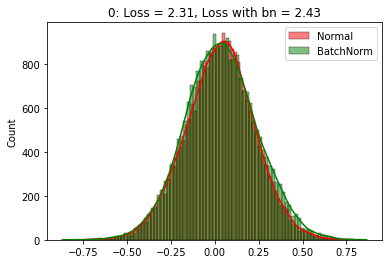

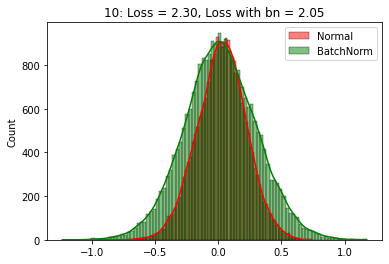

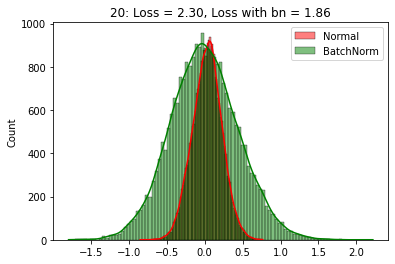

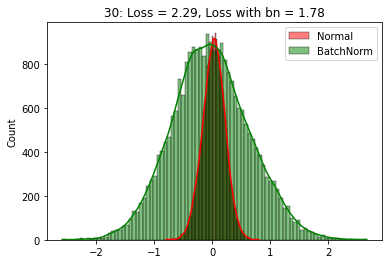

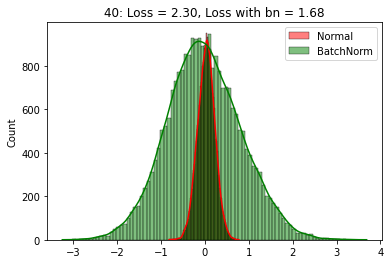

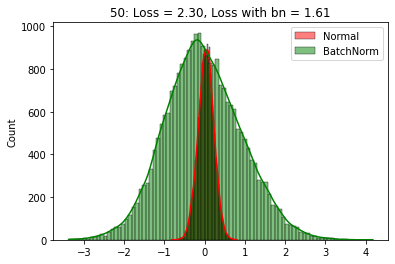

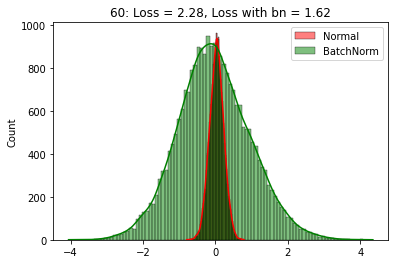

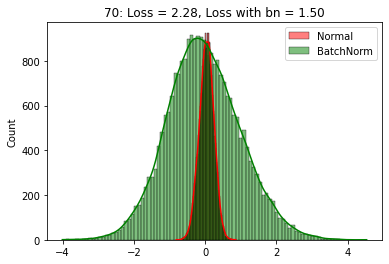

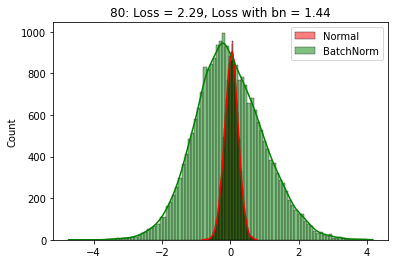

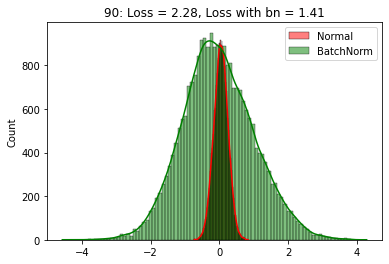

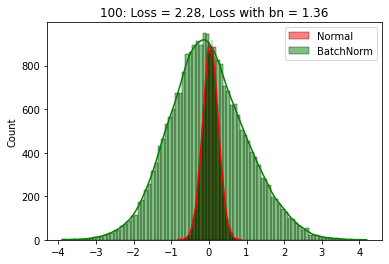

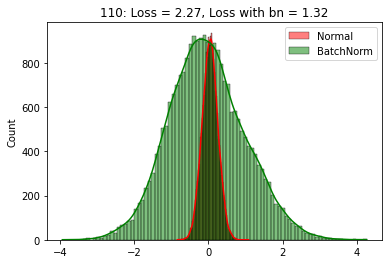

----------------------


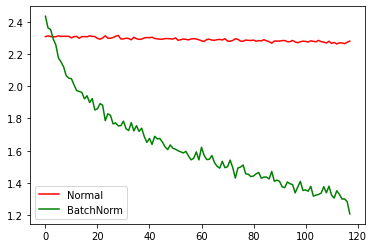

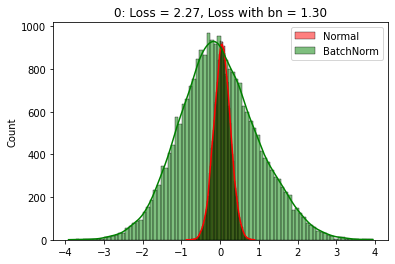

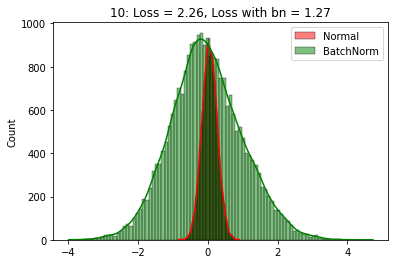

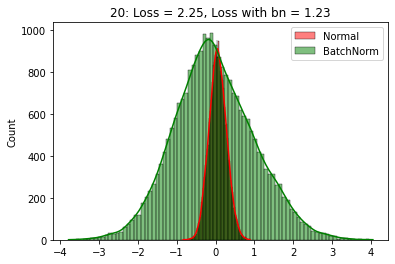

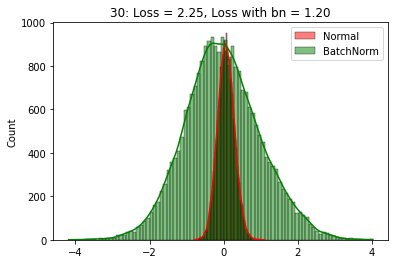

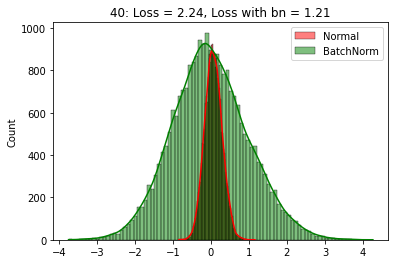

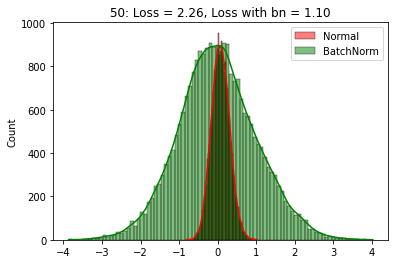

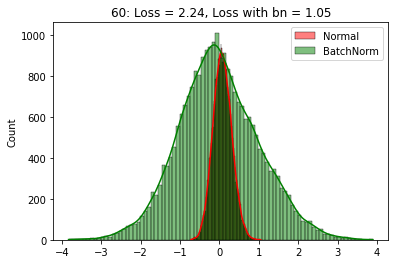

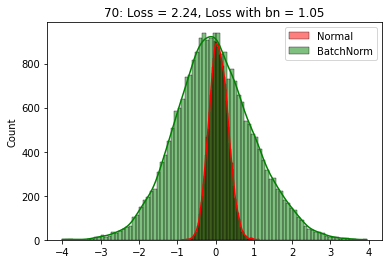

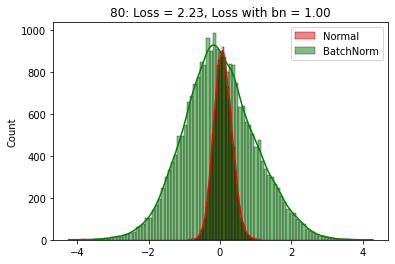

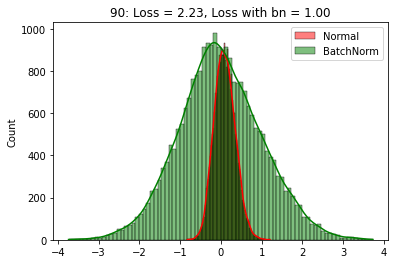

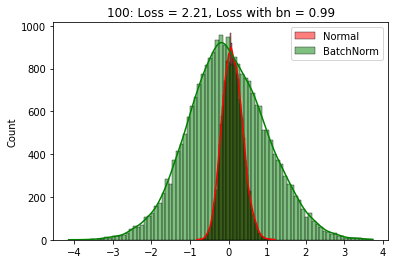

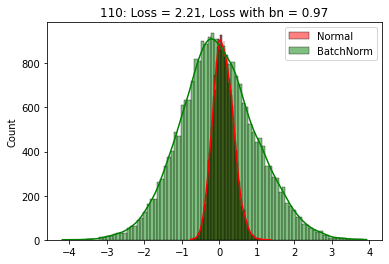

----------------------


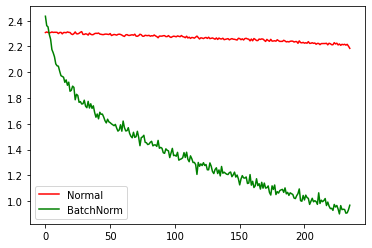

In [12]:
loss_arr = []
loss_bn_arr = []

nun_epochs = 2

for epoch in range(nun_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        ### training steps for normal model
        opt.zero_grad() # reset grad
        # forward pass
        outputs = model(inputs)
        # loss
        loss = loss_fn(outputs, labels)
        # compute gradient
        loss.backward()
        # update parameters
        opt.step()
        
        ### training steps for bn model
        opt_bn.zero_grad() # reset grad
        # forward pass
        outputs_bn = model_bn(inputs)
        # loss function
        loss_bn = loss_fn(outputs_bn, labels)
        # compute gradient
        loss_bn.backward()
        # update parameters
        opt_bn.step()
        
        # logging
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0: # do some visualisation once in some iterations.        
            
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval() # won't change the model, just set in the eval mode.
            model_bn.eval()            
            
            # ouput value - with, without batchnorm
            # without - a; with - b            
            
            # sequentially doing one layer after other.
            a = model.classifier[0](inputs)
            # a is a tensor of activations-when-each-input(in batch)
            
            # uncomment to compare the performance after second batchnorm.
            # a = model.classifier[1](a)
            # a = model.classifier[2](a)
            
            a = a.detach().numpy().ravel()
            # batch size * layer size - that many values. - distribution of all those values (?) 
            # not seperate plot for each neuron.
    
            sns.histplot(a, kde=True, color='r', label='Normal') 
        
        
            
            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
            # uncomment to compare the performance after second batchnorm.
            # b = model_bn.classifier[2](b)
            # b = model_bn.classifier[3](b)
            # b = model_bn.classifier[4](b)
            
            b = b.detach().numpy().ravel()
            
            sns.histplot(b, kde=True, color='g', label='BatchNorm') 
            
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()  # set model in train mode. eval mode only for visualising.
            model_bn.train()
        
        
    print('----------------------')
    
    # plot loss logs
    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

With normalization - the values are becoming more peaky.. - better

loss reducing faster.

significantly better performance. 

### batch norm in convoln layers.

batchnorm'2d' - arg = number of channels in input.

In [13]:
class CNN_BN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    
## class is written this way for the visulisation purpose. insted of calling all layers one by one.. 
# - we can call the sequential. 